# Inputs to crime severity from scraped sources

TODO: REVISE

Not every crime is created equal, so when gauging the "amount" of crime in aggregate, we need an appropriate weighting. This severity weighting can be measured in many ways, here we adopt an approach where we presume the punishment as according to the law appropriately classifies the severity of a crime.

Due to limited readily available data, we use punishment data in IL from 2000 as specified in http://www.crimeandpunishment.net/IL/chart.html. Note we could attempt to get actual sentencing per crime by requesting the data from the Cook County Circuit Court, but that process will take time and has the possibility of yielding limited results. This weighting factor is not meant to be exact, but just by-and-large reasonable.

The crime severity will be at the IUCR level, which we obtain by mapping ILCS data to IUCR codes. Each IUCR will have a low and high range for fines and prison sentences. IUCR to ILCS mappings are obtained from https://github.com/sc3/python-iucr/blob/master/iucr/data/ilcs2iucr.csv.

In [1]:
import pandas as pd
import requests
import numpy as np
import io
import re
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## Crime severity according to 2005-2009 convictions

In [2]:
humble_factor_for_non_prison_sentence = 0.0

In [3]:
from external_lib import statute

In [4]:
crime_convictions = pd.read_csv('./data/cook_county_conviction_records__2005_2009.csv')

In [5]:
crime_convictions.columns

Index(['case_number', 'sequence_number', 'st_address', 'city', 'state',
       'zipcode', 'arrest_date', 'initial_date', 'sex', 'statute', 'chrgdesc',
       'chrgtype', 'chrgtype2', 'chrgclass', 'chrgdisp', 'chrgdispdate',
       'ammndchargstatute', 'ammndchrgdescr', 'ammndchrgtype',
       'ammndchrgclass', 'minsent_years', 'minsent_months', 'minsent_days',
       'minsent_life', 'minsent_death', 'maxsent_years', 'maxsent_months',
       'maxsent_days', 'maxsent_life', 'maxsent_death', 'amtoffine'],
      dtype='object')

In [6]:
# types of crimes
crime_convictions.groupby('chrgdisp').count()['case_number']

chrgdisp
COND DISCH AND OTHER DISC COND       271
CREDIT DEFENDANT FOR TIME SERV    109213
DEF SENT CCDOC, PERIODIC IMP          18
DEF SENT CONDITIONAL DISCHARGE      2211
DEF SENT TO HOME CONFINEMENT         298
DEF SENT TO INDETERMINATE TERM         6
DEF SENT TO LIFE IMPRISONMENT        346
DEF SENT TO PAY RESTITUTION         4214
DEF SENTENCED ILLINOIS DOC        101995
DEF SENTENCED TO COOK CNTY DOC     19827
DEF SENTENCED TO DEATH                 8
DEF SENTENCED TO PROBATION         42445
ELIGIBLE IMPACT PROG-BOOT CAMP      3075
PROB AND OTHER DISC CONDS          22724
SENT PER IMP + OTH DISC COND          10
SENT/CRT SUPV-SOC SERV-SPC CND        37
SENT/CRT SUPV/SPEC CONDS             116
SENTENCED CCDOC BOOT CAMP           4460
SENTENCED TO COMMUNITY SERVICE     10103
SUPERVISION - SOCIAL SERV DEPT       213
Name: case_number, dtype: int64

In [7]:
crime_convictions_no_credit = crime_convictions[~crime_convictions['chrgdisp'].str.contains('CREDIT')]

In [8]:
def parse_code(cd):
    try:
        return statute.parse_statute(' '.join(cd.split()))
    except:
        return []
    
def parse_iucr(cd):
    try:
        return statute.get_iucr(statute.parse_statute(' '.join(cd.split())))
    except:
        return []

In [9]:
def parse_term(days, months, yrs, life_sent):
    return days / 360 + months / 12 + yrs + (80 if life_sent else 0)

def humbled_term(days, months, yrs, life_sent, chrgdisp):
    humble_factor = \
        1.0 if chrgdisp in ['DEF SENTENCED TO COOK CNTY DOC', 'DEF SENTENCED ILLINOIS DOC',
                            'DEF SENT TO LIFE IMPRISONMENT', 'DEF SENTENCED TO DEATH']\
        else humble_factor_for_non_prison_sentence
    return parse_term(days, months, yrs, life_sent) * humble_factor

In [10]:
parsed_convictions_degenerate_rows = crime_convictions_no_credit.copy()[['statute']]
parsed_convictions_degenerate_rows['statute'] = parsed_convictions_degenerate_rows['statute'].map(parse_iucr)

In [11]:
parsed_convictions_degenerate_rows['min_sent'] =\
    crime_convictions_no_credit[['minsent_days', 'minsent_months', 'minsent_years', 'minsent_life', 'chrgdisp']]\
    .apply(lambda row: humbled_term(*row), axis = 1)
# humble all non - imprisonment sentences

In [12]:
parsed_convictions_degenerate_rows['max_sent'] =\
    crime_convictions_no_credit[['maxsent_days', 'maxsent_months', 'maxsent_years', 'maxsent_life', 'chrgdisp']]\
    .apply(lambda row: humbled_term(*row), axis = 1)

Split the degenerate IUCR codes to their own rows.

Note that some convictions have unreasonably large values (999) or missing convictions (NaN), lets cut those out

In [13]:
iucr_row_split = [ [offense.code] + list(row[1:])\
                   for row in parsed_convictions_degenerate_rows.values for offense in row[0] ]

In [14]:
parsed_convictions = pd.DataFrame(iucr_row_split)
parsed_convictions.columns = ['iucr', 'minsent_yrs', 'maxsent_yrs']
parsed_convictions['iucr_category'] = parsed_convictions['iucr'].str[:2]
parsed_convictions = parsed_convictions[(parsed_convictions['minsent_yrs'] < 100) &\
                                        ~parsed_convictions['minsent_yrs'].isnull()]
# Include category-level for matching later on. IUCR categories are defined by the first 2 digits in the IUCR code
parsed_convictions_category_level = parsed_convictions.copy()
parsed_convictions_category_level['iucr'] = parsed_convictions_category_level['iucr'].str[:2] + 'XX'
parsed_convictions = pd.concat([parsed_convictions, parsed_convictions_category_level])

In [15]:
parsed_convictions_minsent = parsed_convictions.groupby('iucr')['minsent_yrs']\
    .agg(['mean', 'median', 'min', 'max'])

In [19]:
parsed_convictions_minsent

,mean,median,min,max
iucr,,,,
0110,26.341289,22.000000,0.000000,95.0
0115,23.722222,30.000000,0.000000,50.0
0130,9.500000,7.000000,4.000000,20.0
0141,3.738734,3.000000,0.000000,20.0
0142,3.738734,3.000000,0.000000,20.0
0160,4.013523,5.000000,0.000000,14.0
0165,6.600000,5.000000,4.000000,14.0
0170,7.400000,7.000000,4.000000,10.0
01XX,23.678793,20.000000,0.000000,95.0


In [17]:
parsed_convictions_minsent.head()

,mean,median,min,max
iucr,,,,
0110,26.341289,22.0,0.0,95.0
0115,23.722222,30.0,0.0,50.0
0130,9.500000,7.0,4.0,20.0
0141,3.738734,3.0,0.0,20.0
0142,3.738734,3.0,0.0,20.0


In [18]:
parsed_convictions_minsent.to_csv('./data/parsed_convictions_minsent.csv')

# Sandbox

## Fine stats

Generally fines do not seem like a big deal and whether or not we incorporate them should not meaningfully affect crime measurements.
* Affects <2% of all outcomes
* Of those that it does affect, the median is $1000 fine
* There are some larger fines in this 5 year sample (up to \$30000), but these can be basically counted on one hand

In [19]:
crime_convictions_no_credit.columns

Index(['case_number', 'sequence_number', 'st_address', 'city', 'state',
       'zipcode', 'arrest_date', 'initial_date', 'sex', 'statute', 'chrgdesc',
       'chrgtype', 'chrgtype2', 'chrgclass', 'chrgdisp', 'chrgdispdate',
       'ammndchargstatute', 'ammndchrgdescr', 'ammndchrgtype',
       'ammndchrgclass', 'minsent_years', 'minsent_months', 'minsent_days',
       'minsent_life', 'minsent_death', 'maxsent_years', 'maxsent_months',
       'maxsent_days', 'maxsent_life', 'maxsent_death', 'amtoffine'],
      dtype='object')

In [27]:
fines = crime_convictions_no_credit.query('amtoffine > 0')

In [29]:
len(fines['amtoffine']) / len(crime_convictions_no_credit) # fines affect < 2% of convictions

0.014441300140787374

In [31]:
print("mean fine:", fines['amtoffine'].mean())
print("median fine:", fines['amtoffine'].median())

mean fine: 2960.11020541
median fine: 1000.0


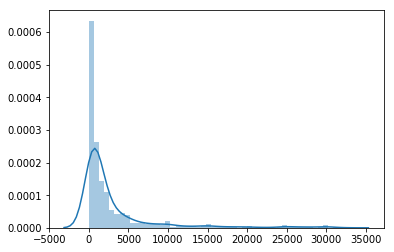

In [32]:
sns.distplot(fines['amtoffine'].values)

plt.show()

## ILCS to IUCR mapping

Simply pulled in from the site above

In [ ]:
ilcs_iucr_mapping_url = 'https://raw.githubusercontent.com/sc3/python-iucr/master/iucr/data/ilcs2iucr.csv'

In [ ]:
ilcs_iucr_mapping = pd.read_csv(io.StringIO(requests.get(ilcs_iucr_mapping_url).content.decode('utf-8')))\
    .rename(columns = {'code' : 'iucr', 'ilcs_reference' : 'ilcs'})[['iucr', 'ilcs', 'offense']]

In [ ]:
ilcs_iucr_mapping['ilcs'] = ilcs_iucr_mapping['ilcs'].str.lower()

In [ ]:
ilcs_iucr_mapping.head()

## Crime severity according to ILCS codes

The crime data is not laid out in a clean table, and also contains many conditionals such as first offense, second offense, whether or not an arrest involved firearm discharge, etc. Much of this type of information is not available to us in the chicago data portal dataset. For the sake of this analysis, we will consider only the first offense punishment.

In [ ]:
punishment_url_IL_2000 = 'http://www.crimeandpunishment.net/IL/chart.html'

In [ ]:
# Drop the first few rows of the table that contain conditional info
raw_punishment_table = pd.read_html(punishment_url_IL_2000)[0].loc[8:]

In [ ]:
raw_punishment_table = raw_punishment_table.rename(columns = {0:'crime', 1:'primary_penalty', 2:'secondary_penalty'})

In [ ]:
raw_punishment_table.head(10)

In [ ]:
raw_punishment_valid_rows = raw_punishment_table[
    raw_punishment_table['crime'].str.contains(' ILCS ') & ~raw_punishment_table['primary_penalty'].isnull()
].reset_index(drop = True)

In [ ]:
raw_punishment_valid_rows.head(10)

In [ ]:
def parse_ilcs_code(s):
    words = s.split()
    ilcs_idx = words.index('ILCS')
    return '-'.join([words[ilcs_idx-1], words[ilcs_idx+1]]).lower()

Because some ILCS pop up in many rows, take the first row for each ILCS. This occurs when the table is formatted in such a way that second, third, ... or variations of a crime show up in multiple rows. We don't want these because we lack conditional information with crimes.

In [ ]:
raw_punishement_with_ilcs_parsed = raw_punishment_valid_rows.copy()
raw_punishement_with_ilcs_parsed['ilcs'] = raw_punishement_with_ilcs_parsed['crime'].map(parse_ilcs_code)
raw_punishement_with_ilcs_parsed = raw_punishement_with_ilcs_parsed\
    .sort_values('ilcs')\
    .drop_duplicates(subset = ['ilcs'])\
    .sort_index()\
    .reset_index(drop = True)

In [ ]:
raw_punishement_with_ilcs_parsed.head(10)

### Rules for discerning punishment ranges

1. Fines are prefixed with \$, other numbers are sentencing terms
2. If a row has two fines, then we know the range. If it contains one fine, then we assume the other is 0 (the "up to" rule). Likewise for jail sentences.

In [ ]:
def parse_terms(s):
    words = s.split()
    terms = [ int(w) for w in words if w.isdigit() ]
    if len(terms) == 0:
        return [0, 0]
    elif len(terms) == 1:
        return [0, terms[0]]
    elif len(terms) == 2:
        return terms
    else:
        print("encountered 3 numbers when looking for terms, taking first 2: ", s)
        return terms[:2]
    
def parse_fines(s):
    words = s.split()
    fines = [ int(w.replace(',', '').replace('$', '')) for w in words\
                if '$' in w and w.replace(',', '').replace('$', '').isdigit()]
    if len(fines) == 0:
        return [0, 0]
    elif len(fines) == 1:
        return [0, fines[0]]
    elif len(fines) == 2:
        return fines
    else:
        print("encountered 3 numbers when looking for fines, taking first 2: ", s)
        fines[:2]

In [ ]:
severity = raw_punishement_with_ilcs_parsed[['ilcs']].copy()

In [ ]:
severity['min_term'], severity['max_term'] = \
    zip(*raw_punishement_with_ilcs_parsed['primary_penalty'].map(parse_terms))

In [ ]:
severity['min_fine'], severity['max_fine'] = \
    zip(*raw_punishement_with_ilcs_parsed['primary_penalty'].map(parse_fines))

In [ ]:
severity.head(10)

In [ ]:
severity_with_iucr = severity.set_index('ilcs')\
    .join(ilcs_iucr_mapping.set_index('ilcs'), how = 'left')\
    .reset_index()
severity_with_iucr = severity_with_iucr[~severity_with_iucr['iucr'].isnull()]
severity_with_iucr['iucr'] = severity_with_iucr['iucr'].map(int)
severity_with_iucr = severity_with_iucr.set_index('iucr')

## Crime IUCR coverage

Given these penalties, what coverage do we have? For codes that we don't cover, are we missing a significant portion of crimes? We will look at total crime coverage by those that we have mapped. We find that by count, this gives us roughly 2/3 coverage of crimes. Not fantastic.

In [ ]:
crimes = pd.read_csv('./data/cleaned_crimes.csv')[['iucr']]
crimes['iucr_for_join'] = crimes['iucr'].map(lambda x: int(re.sub('\D', '0', x)))

In [ ]:
iucr_counts = crimes.groupby('iucr_for_join').count().rename(columns = {'iucr' : 'count'})

In [ ]:
count_check = iucr_counts.join(severity_with_iucr, how = 'left')
count_check['map_success'] = ~count_check['ilcs'].isnull()

In [ ]:
count_check[count_check['map_success']]['count'].sum() / count_check['count'].sum()

Which crimes are we missing?

In [ ]:
count_check[~count_check['map_success']].sort_values('count', ascending = False).head(20)['count'].plot(kind = 'bar')

plt.show()

We can make a lot of progress by mapping these guys by hand. 

In [ ]:
test_join = severity.set_index('ilcs').join(ilcs_iucr_mapping.set_index('ilcs'), how = 'left')

In [ ]:
test_join[~test_join['iucr'].isnull()]

In [ ]:
test_join[test_join['iucr'].isnull()]

In [ ]:
iucr_needed = pd.read_csv('./data/cleaned_crimes.csv')['iucr'].unique()
iucr_needed = set(map(lambda x: int(re.sub('\D', '0', x)), iucr_needed))

In [ ]:
iucr_found = test_join[~test_join['iucr'].isnull()]['iucr'].map(int)

In [ ]:
needed_but_not_mapped = [ code for code in iucr_needed if code in iucr_found ]

In [ ]:
len(iucr_needed)

In [ ]:
len(iucr_found)

In [ ]:
list(zip(sorted(iucr_needed)[-20:], sorted(iucr_found)[-20:]))